# 基于FMA数据集实现的多层次音乐流派分类器

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import librosa
import torchaudio
import torchaudio.transforms as T
from torchvision import transforms, models
from torchinfo import summary
from tqdm import tqdm
from utils import FMADataset

## 多流派分类

### 数据集处理

In [7]:
sample_rate = 12000
n_fft = 512
hop_length = 256
n_mels = 96

数据集的定义在 `utils/FMADataset.py` 中，这里我们直接使用它。

In [76]:
fma_train = FMADataset(
    metadata_dir="./albums/train/fma_metadata",
    audio_dir="./albums/train/fma_small",
    duration=29.12,
    train=True,
    sample_rate=sample_rate,
)
fma_val = FMADataset(
    metadata_dir="./albums/train/fma_metadata",
    audio_dir="./albums/train/fma_small",
    duration=29.12,
    train=False,
    validation=True,
    sample_rate=sample_rate,
)
fma_test = FMADataset(
    metadata_dir="./albums/train/fma_metadata",
    audio_dir="./albums/train/fma_small",
    duration=29.12,
    train=False,
    validation=False,
    sample_rate=sample_rate,
)

### 数据集分析

查找数据集中损坏的音频文件。

In [ ]:
from torchaudio.backend import sox_io_backend

bad_files = []
for track_id in fma_train.tracks.index:
    path = fma_train._get_audio_path(track_id)
    try:
        _ = torchaudio.load(path)
    except Exception as e:
        print(f"Corrupted file: {path} — {e}")
        bad_files.append(track_id)


In [77]:
len(fma_train), len(fma_val), len(fma_test)

(6400, 800, 800)

`FMA_Small`数据集中音频文件的数量分布。

In [4]:
train_tracks = pd.read_csv('./albums/train/fma_metadata/tracks.csv', header=[0, 1], index_col=0)
train_tops = [train_tracks.loc[idx, 'track']['genre_top'] for idx in fma_train.tracks.index]
test_tops = [train_tracks.loc[idx, 'track']['genre_top'] for idx in fma_test.tracks.index]
val_tops = [train_tracks.loc[idx, 'track']['genre_top'] for idx in fma_val.tracks.index]

In [5]:
audio_top = [x[2] if x is not None else None for x in fma_val]

In [6]:
from collections import Counter

train_dist = Counter(train_tops)
test_dist = Counter(test_tops)
val_dist = Counter(val_tops)
audio_dist = Counter(audio_top)

In [8]:
train_dist, test_dist, val_dist, audio_dist

(Counter({'Hip-Hop': 800,
          'Pop': 800,
          'Folk': 800,
          'Rock': 800,
          'Experimental': 800,
          'International': 800,
          'Electronic': 800,
          'Instrumental': 800}),
 Counter({'Rock': 100,
          'International': 100,
          'Folk': 100,
          'Experimental': 100,
          'Instrumental': 100,
          'Pop': 100,
          'Hip-Hop': 100,
          'Electronic': 100}),
 Counter({'Experimental': 100,
          'Rock': 100,
          'Folk': 100,
          'Pop': 100,
          'International': 100,
          'Electronic': 100,
          'Hip-Hop': 100,
          'Instrumental': 100}),
 Counter({38: 100,
          12: 100,
          17: 100,
          10: 100,
          2: 100,
          15: 100,
          21: 100,
          1235: 100}))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

all_counts = {k: train_dist.get(k, 0) + val_dist.get(k, 0) + test_dist.get(k, 0)
              for k in set(train_dist) | set(val_dist) | set(test_dist)}

# 根据总样本数降序排列类别
sorted_labels = sorted(all_counts.keys(), key=lambda k: all_counts[k], reverse=True)

# 按统一顺序获取值
train_vals = [train_dist.get(label, 0) for label in sorted_labels]
val_vals = [val_dist.get(label, 0) for label in sorted_labels]
test_vals = [test_dist.get(label, 0) for label in sorted_labels]

# 使用seaborn美观风格
sns.set_theme(style="whitegrid")

# 开始绘图
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
width = 0.25
x = range(len(sorted_labels))

ax.bar([i - width for i in x], train_vals, width=width, label='Train', color='#4C72B0')
ax.bar(x, val_vals, width=width, label='Val', color='#55A868')
ax.bar([i + width for i in x], test_vals, width=width, label='Test', color='#C44E52')

# 标签设置
ax.set_xticks(x)
ax.set_xticklabels(sorted_labels, rotation=45, ha='right')
ax.set_ylabel("Sample Count")
ax.set_title("Class Distribution in Train / Val / Test", fontsize=13)
ax.legend()
plt.tight_layout()

# 可选：保存为矢量图用于论文
plt.savefig("./figures/class_distribution.pdf", bbox_inches='tight')
plt.show()


### 频谱化

In [9]:
def log_mel(waveform, sample_rate=12000, hop_length=256):
    mel_spec = librosa.feature.melspectrogram(
        y=waveform.numpy(),
        sr=sample_rate,
        hop_length=hop_length,
        n_fft=512,
        n_mels=96,
        power=2.0,
    )
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-9)
    return torch.tensor(log_mel)

In [10]:
def CQT(waveform, sample_rate=22050, hop_length=512):
    cqt = librosa.cqt(
        waveform.numpy(),
        sr=sample_rate,
        hop_length=hop_length,
        n_bins=84,
        bins_per_octave=12,
    )
    cqt_mag = np.abs(cqt)
    cqt_db = librosa.amplitude_to_db(cqt_mag, ref=np.max)
    cqt_db = (cqt_db - cqt_db.mean()) / (cqt_db.std() + 1e-9)
    return torch.tensor(cqt_db)

In [11]:
def Chroma(waveform, sample_rate=22050, hop_length=512):
    chroma = librosa.feature.chroma_stft(
        y=waveform.numpy(),
        sr=sample_rate,
        hop_length=hop_length,
        n_fft=2048,
        n_chroma=12,
    )
    chroma = (chroma - chroma.mean()) / (chroma.std() + 1e-9)
    return torch.tensor(chroma)

`TODO`: 分别展示8个类别中的音频样本，并展示其对应的log mel, CQT, chroma图。

In [12]:
sample = fma_train[32][0]
lm = log_mel(sample)
cqt = CQT(sample)
ch = Chroma(sample)

In [13]:
sample.shape

torch.Size([1, 349440])

In [21]:
def set_universal_plot_style():
    import matplotlib.pyplot as plt
    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "savefig.facecolor": "white",
        "text.color": "#2E2E2E",
        "axes.labelcolor": "#444444",
        "axes.edgecolor": "#444444",
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "grid.color": "#DDDDDD",
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "legend.edgecolor": "#CCCCCC",
        "legend.facecolor": "white",
    })


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

set_universal_plot_style()
# 设置全局字体为 Times New Roman，字号统一
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 14

# 假设采样率
sr = 12000
duration = sample.shape[-1] / sr
time = np.linspace(0, duration, sample.shape[-1])

fig, axes = plt.subplots(2, 2, figsize=(12, 7), dpi=300)  # 高清分辨率

# 1. Waveform
axes[0, 0].plot(time, sample.t().numpy(), color='navy', linewidth=0.8)
axes[0, 0].set_title("Waveform")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude")

# 2. Log-Mel Spectrogram
img1 = axes[0, 1].imshow(lm[0].numpy(), aspect="auto", origin="lower", cmap="magma")
axes[0, 1].set_title("Log-Mel Spectrogram")
axes[0, 1].set_xlabel("Time Frame")
axes[0, 1].set_ylabel("Mel Bin")
fig.colorbar(img1, ax=axes[0, 1], format="%.2f", fraction=0.046, pad=0.04)

# 3. Constant-Q Transform
img2 = axes[1, 0].imshow(cqt[0].numpy(), aspect="auto", origin="lower", cmap="plasma")
axes[1, 0].set_title("Constant-Q Transform")
axes[1, 0].set_xlabel("Time Frame")
axes[1, 0].set_ylabel("Frequency Bin")
fig.colorbar(img2, ax=axes[1, 0], format="%.2f", fraction=0.046, pad=0.04)

# 4. Chroma
img3 = axes[1, 1].imshow(ch[0].numpy(), aspect="auto", origin="lower", cmap="inferno")
axes[1, 1].set_title("Chroma Features")
axes[1, 1].set_xlabel("Time Frame")
axes[1, 1].set_ylabel("Chroma Bin")
fig.colorbar(img3, ax=axes[1, 1], format="%.2f", fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("./figures/audio_features_highres.pdf", dpi=600, bbox_inches='tight', transparent=True)
plt.show()


### 数据处理

In [20]:
# id_mappings = {12: 0,
#                15: 1,
#                38: 2,
#                21: 3,
#                5: 4,
#                17: 5,
#                8: 6,
#                4: 7,
#                1235: 8,
#                10: 9,
#                9: 10,
#                14: 11,
#                20: 12,
#                3: 13,
#                2: 14,
#                13: 15,}

id_mappings = {
    2: 0,
    10: 1,
    12: 2,
    15: 3,
    17: 4,
    21: 5,
    38: 6,
    1235: 7,
}

def Resize(features, target_F, chunk=False):
    if not chunk:
        resized = []
        for feat in features:
            _, f, t = feat.shape
            feat = feat.unsqueeze(0)
            feat = F.interpolate(
                feat, size=(target_F, t), mode="bilinear", align_corners=False
            )
            resized.append(feat.squeeze(0))

    else:
        resized = []
        for feat in features:
            _, _, _, t = feat.shape
            feat = feat
            feat = F.interpolate(
                feat, size=(target_F, t), mode="bilinear", align_corners=False
            )
            resized.append(feat)

    return torch.stack(resized)


def make_chunk(waveform, sample_rate=22050, chunk_time=15, time_step=7.5):
    chunk_size = int(sample_rate * chunk_time)
    step_size = int(sample_rate * time_step)
    chunks = waveform.unfold(dimension=1, size=chunk_size, step=step_size)
    return chunks


def process_chunks(waveforms, feature_fn):
    flat_waveforms = [w for chunk in waveforms for w in chunk.squeeze(0)]
    features = [feature_fn(w).unsqueeze(0) for w in flat_waveforms]
    n_chunks = waveforms[0].shape[1]

    grouped_features = [
        torch.stack(features[i : i + n_chunks])
        for i in range(0, len(features), n_chunks)
    ]

    return grouped_features


def collate_fn(batch, chunk=False, one_hot=False, resize=True):
    batch = [b for b in batch if b is not None]  # 过滤掉无效项
    if len(batch) == 0:
        return None, None, None  # 所有项都无效
    waveforms, genres, genre_tops = zip(*batch)
    genre_tops = [id_mappings[genre_top] for genre_top in genre_tops]
    genre_tops = torch.tensor(genre_tops)
    genres = torch.stack(genres)
    num_classes = len(id_mappings)
    if chunk:
        waveforms = [make_chunk(waveform) for waveform in waveforms]
        mel_specs = torch.stack(process_chunks(waveforms, log_mel))
        cqt = torch.stack(process_chunks(waveforms, CQT))
        chroma = torch.stack(process_chunks(waveforms, Chroma))
        if one_hot:
            genre_tops = torch.nn.functional.one_hot(
                genre_tops, num_classes=num_classes
            )
            genre_tops = genre_tops.unsqueeze(1)
            genre_tops = genre_tops.expand(-1, mel_specs.shape[1], -1).reshape(
                -1, genre_tops.shape[-1]
            )
        else:
            genre_tops = genre_tops.unsqueeze(1).repeat(1, mel_specs.shape[1]).view(-1)
        genres = genres.repeat_interleave(mel_specs.shape[1], dim=0)
        if resize:
            F_mel = mel_specs[-1].shape[2]
            F_cqt = cqt[-1].shape[2]
            F_chroma = chroma[-1].shape[2]
            F_max = max(F_mel, F_cqt, F_chroma)
            mel_specs = Resize(mel_specs, F_max, chunk)
            cqt = Resize(cqt, F_max, chunk)
            chroma = Resize(chroma, F_max, chunk)
            mel_specs = mel_specs.reshape(-1, *mel_specs.shape[2:])
            cqt = cqt.reshape(-1, *cqt.shape[2:])
            chroma = chroma.reshape(-1, *chroma.shape[2:])
            feat = torch.cat((mel_specs, cqt, chroma), dim=1)
        else:
            mel_specs = mel_specs.reshape(-1, *mel_specs.shape[2:])
            cqt = cqt.reshape(-1, *cqt.shape[2:])
            chroma = chroma.reshape(-1, *chroma.shape[2:])
            feat = (mel_specs, cqt, chroma)

    else:
        mel_specs = torch.stack([log_mel(waveform[0]).unsqueeze(0) for waveform in waveforms])
        cqt = torch.stack([CQT(waveform[0]).unsqueeze(0) for waveform in waveforms])
        chroma = torch.stack([Chroma(waveform[0]).unsqueeze(0) for waveform in waveforms])
        if one_hot:
            genre_tops = torch.nn.functional.one_hot(
                genre_tops, num_classes=num_classes
            )
            genre_tops = genre_tops.unsqueeze(1)
            genre_tops = genre_tops.expand(-1, mel_specs.shape[1], -1).reshape(
                -1, genre_tops.shape[-1]
            )
        else:
            genre_tops = genre_tops.unsqueeze(1).repeat(1, mel_specs.shape[1]).view(-1)
        if resize:
            F_mel = mel_specs[-1].shape[1]
            F_cqt = cqt[-1].shape[1]
            F_chroma = chroma[-1].shape[1]
            F_max = max(F_mel, F_cqt, F_chroma)
            mel_specs = Resize(mel_specs, F_max, chunk)
            cqt = Resize(cqt, F_max, chunk)
            chroma = Resize(chroma, F_max, chunk)
            feat = torch.cat((mel_specs, cqt, chroma), dim=1)
        else:
            feat = (mel_specs, cqt, chroma)
    return feat, genres, genre_tops

In [21]:
from functools import partial
fn =partial(collate_fn, chunk=False, one_hot=False, resize=False)

In [22]:
test_loader = DataLoader(
    fma_test,
    batch_size=8,
    shuffle=False,
    collate_fn=fn,
    num_workers=0,
    pin_memory=True
)
train_loader = DataLoader(
    fma_train,
    batch_size=8,
    shuffle=True,
    collate_fn=fn,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    fma_val,
    batch_size=8,
    shuffle=False,
    collate_fn=fn,
    num_workers=0,
    pin_memory=True
)

In [23]:
for feat, genres, tops in train_loader:
    mel, cqt, chroma = feat
    print(mel.shape, cqt.shape, chroma.shape)
    print(tops.shape)
    print(tops)
    print(genres.shape)
    # print(feat.shape)
    # print(tops.shape)
    break

torch.Size([8, 1, 96, 1366]) torch.Size([8, 1, 84, 683]) torch.Size([8, 1, 12, 683])
torch.Size([8])
tensor([5, 4, 7, 4, 4, 4, 1, 4])
torch.Size([8, 163])


### TemporalCNN在测试集上的性能分析

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
# 混淆矩阵
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, f1_score
import seaborn as sns

idx_id = {v: k for k, v in id_mappings.items()}
id_name = {v: fma_test.genre_id_to_name[v] for k, v in idx_id.items()}


In [26]:
id_name, idx_id

({2: 'International',
  10: 'Pop',
  12: 'Rock',
  15: 'Electronic',
  17: 'Folk',
  21: 'Hip-Hop',
  38: 'Experimental',
  1235: 'Instrumental'},
 {0: 2, 1: 10, 2: 12, 3: 15, 4: 17, 5: 21, 6: 38, 7: 1235})

In [27]:
from model import DeepCRNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCRNN(num_classes=8).to(device)
model.load_state_dict(torch.load('./checkpoint/DeepCRNN_epoch_22_20250511_194423.pth', map_location=device))

C:\Users\Vast Sue\AppData\Local\Temp\ipykernel_25096\757447528.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoint/DeepCRNN_ep

<All keys matched successfully>

In [32]:
model.eval()
all_outputs = []
all_labels = []
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Validation", total=len(test_loader))
    for feat, genres, genre_tops in test_bar:
        mel_specs, cqt, chroma = feat
        mel_specs = mel_specs.to(device)
        genre_tops = genre_tops.to(device)
        outputs = model(mel_specs)
        loss = criterion(outputs, genre_tops)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += genre_tops.size(0)
        correct += (predicted == genre_tops).sum().item()
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(genre_tops.cpu().numpy())
print(f"Test Loss: {test_loss / len(test_loader)}")

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
all_outputs = np.concatenate(all_outputs)
all_labels = np.concatenate(all_labels)

Validation: 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]

Test Loss: 1.4502907890081405
Test Accuracy: 51.88%


Top-1 Accuracy: 51.88%
Top-3 Accuracy: 83.00%
               precision    recall  f1-score   support

International       0.63      0.48      0.55       100
          Pop       0.40      0.52      0.45       100
         Rock       0.75      0.47      0.58       100
   Electronic       0.70      0.61      0.65       100
         Folk       0.30      0.34      0.32       100
      Hip-Hop       0.73      0.88      0.80       100
 Experimental       0.36      0.45      0.40       100
 Instrumental       0.47      0.40      0.43       100

     accuracy                           0.52       800
    macro avg       0.54      0.52      0.52       800
 weighted avg       0.54      0.52      0.52       800



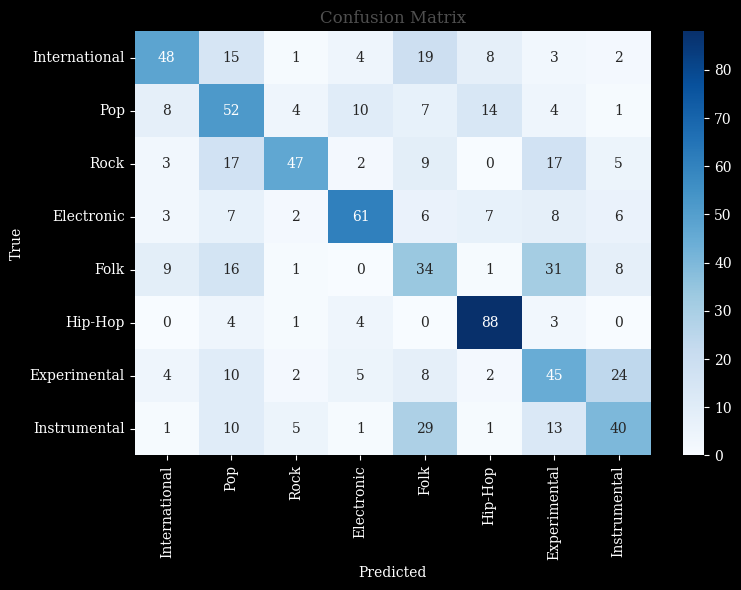

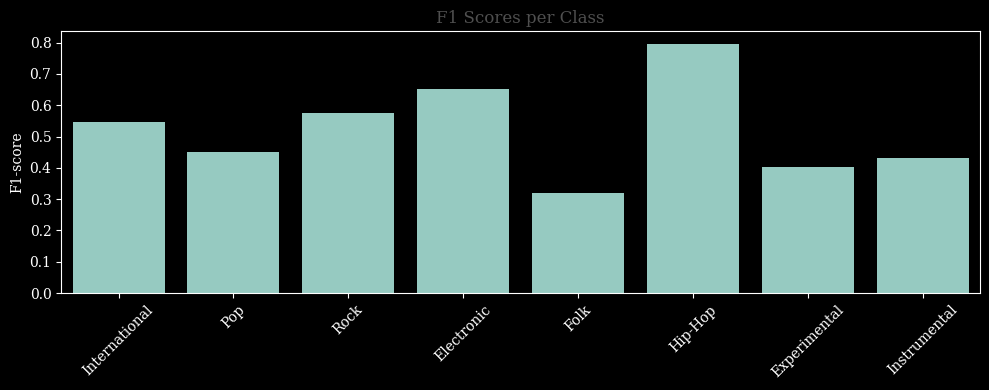

In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 假设你已经拿到了如下两个变量：
# all_outputs: 模型的输出 logits，形状为 (num_samples, num_classes)
# all_labels: 真实标签，形状为 (num_samples,)

# 定义类别名称
class_names = list(id_name.values())
num_classes = len(class_names)

# Top-1 accuracy
y_pred = np.argmax(all_outputs, axis=1)
accuracy = 100 * np.sum(y_pred == all_labels) / len(all_labels)
print(f"Top-1 Accuracy: {accuracy:.2f}%")

# Top-3 accuracy
outputs_tensor = torch.tensor(all_outputs)
labels_tensor = torch.tensor(all_labels)
topk = 3
_, topk_preds = outputs_tensor.topk(topk, dim=1)
correct_topk = topk_preds.eq(labels_tensor.unsqueeze(1).expand_as(topk_preds)).sum().item()
top3_accuracy = 100 * correct_topk / len(all_labels)
print(f"Top-3 Accuracy: {top3_accuracy:.2f}%")

# 分类报告
report = classification_report(all_labels, y_pred, target_names=class_names)
print(report)

# 混淆矩阵
conf_mat = confusion_matrix(all_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# F1 分数条形图
report_dict = classification_report(all_labels, y_pred, target_names=class_names, output_dict=True)
f1_scores = [report_dict[label]["f1-score"] for label in class_names]

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=f1_scores)
plt.title("F1 Scores per Class")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [43]:
import matplotlib.pyplot as plt
plt.style.use('default')  # 或者试试 plt.style.use('seaborn-whitegrid')


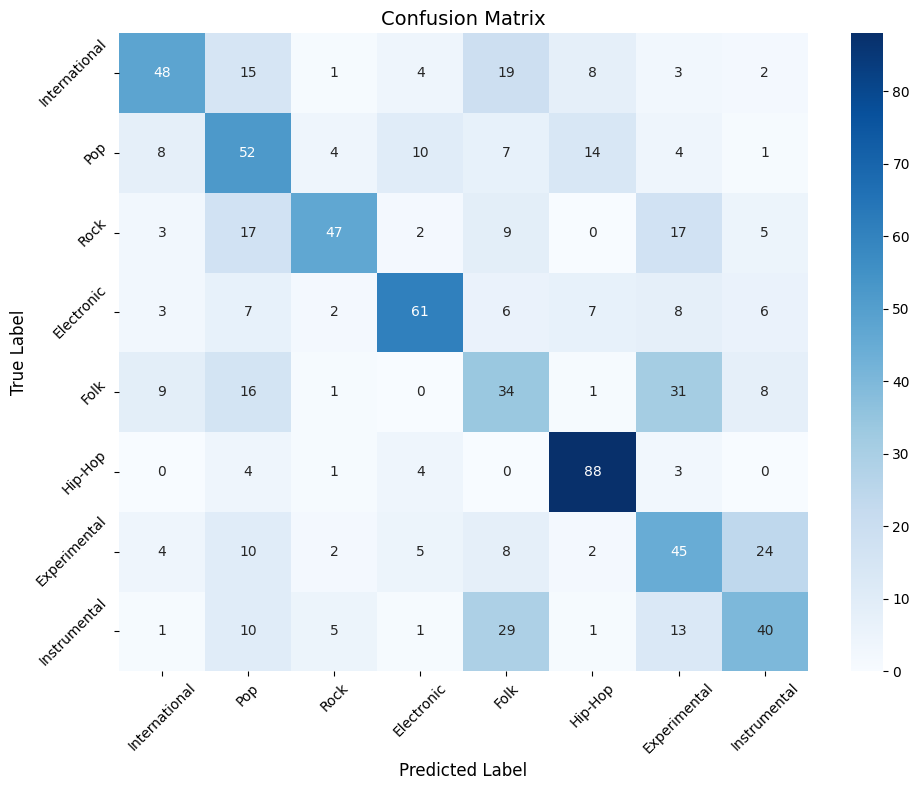

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("./figures/confusion_matrix.pdf", dpi=300, transparent=True)
plt.show()


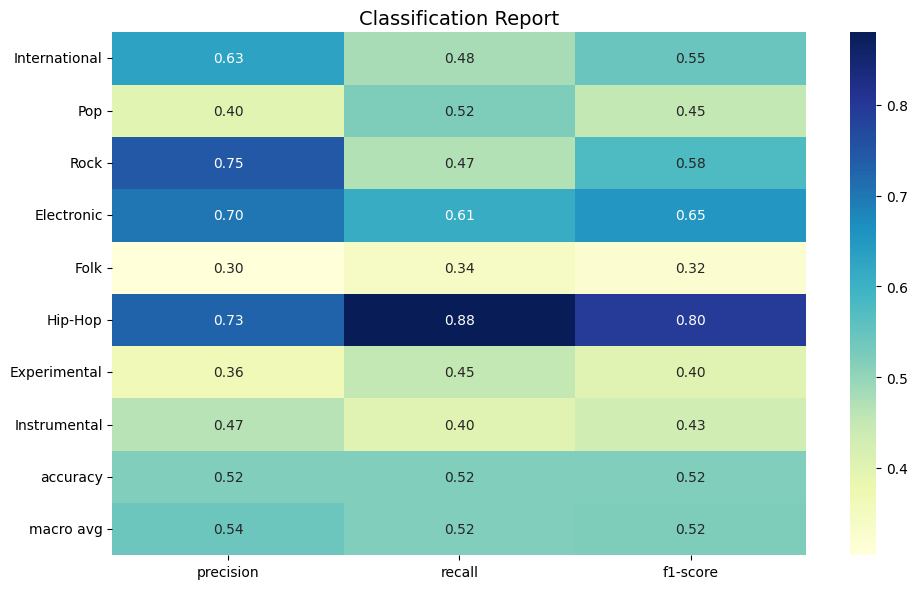

In [48]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(all_labels, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Classification Report", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("./figures/classification_report.pdf", dpi=300, transparent=True)
plt.show()


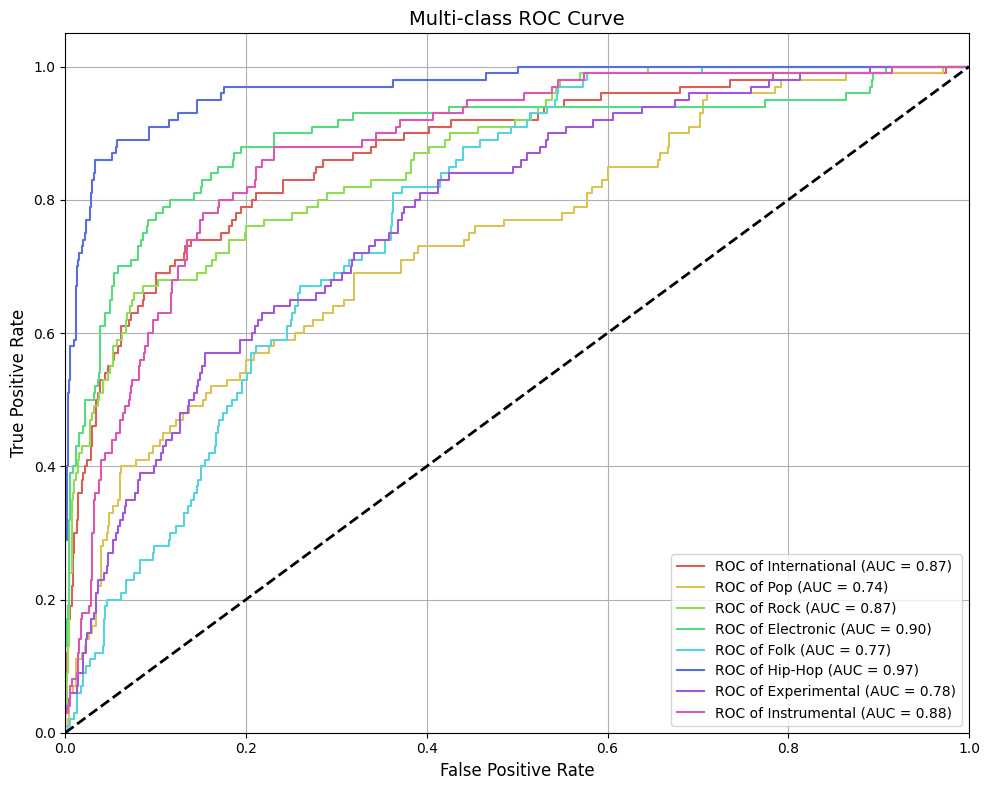

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

# 假设你有 softmax 概率输出：probs = model(mel_specs).softmax(dim=1).cpu().numpy()
# 并且有：n_classes = len(class_names)
y_true = label_binarize(all_labels, classes=list(range(len(class_names))))
n_classes = y_true.shape[1]

# probs shape: (n_samples, n_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(sns.color_palette("hls", n_classes))

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/roc_curve.pdf", dpi=300, transparent=True)
plt.show()


In [48]:
true_labels = np.argmax(all_labels, axis=1)
predicted = np.argmax(all_outputs, axis=1)
cm = confusion_matrix(true_labels, predicted)
macro_f1 = f1_score(true_labels, predicted, average='macro')

print(f"Confusion Matrix:\n{cm}")
print(f"Macro F1 Score: {macro_f1:.2f}")

Confusion Matrix:
[[645  34  22   6  48  25   4  16]
 [ 38 408 127  15 108  25  29  50]
 [  4  53 650   3  31   5  21  32]
 [ 15  31  27 551   5  65  18  87]
 [ 13  40  49   0 655   2   7  34]
 [ 19   7  16  15   4 722   2  12]
 [ 32  48  61  21  73  25 450  89]
 [  8  25  55  13  41   1  29 628]]
Macro F1 Score: 0.73


In [49]:
n_classes = all_labels.shape[1]
class_names = [f"{id_name[idx_id[i]]}" for i in range(n_classes)]  # 如果你有具体名字可以替换掉

In [1]:
import json


In [69]:
log = json.load(open('./checkpoint/TCNNbase_log.json', 'r'))

In [70]:
log

[{'epoch': 1,
  'train_loss': 1.8376568818092347,
  'train_accuracy': 29.46512355333125,
  'val_loss': 1.97166095495224,
  'val_accuracy': 29.5},
 {'epoch': 2,
  'train_loss': 1.5918115063756704,
  'train_accuracy': 41.820456678135756,
  'val_loss': 1.648435304760933,
  'val_accuracy': 39.625},
 {'epoch': 3,
  'train_loss': 1.3632756981998682,
  'train_accuracy': 51.31373162339693,
  'val_loss': 1.6033436205983163,
  'val_accuracy': 47.5},
 {'epoch': 4,
  'train_loss': 1.0067533790692687,
  'train_accuracy': 64.63872380356584,
  'val_loss': 1.9642337700724601,
  'val_accuracy': 38.75},
 {'epoch': 5,
  'train_loss': 0.5890203080838546,
  'train_accuracy': 79.08977166093213,
  'val_loss': 2.5834924934804437,
  'val_accuracy': 42.75},
 {'epoch': 6,
  'train_loss': 0.32634206351445755,
  'train_accuracy': 89.05223647169221,
  'val_loss': 3.970443308353424,
  'val_accuracy': 36.375},
 {'epoch': 7,
  'train_loss': 0.2811975197312131,
  'train_accuracy': 91.21050985298717,
  'val_loss': 3.753

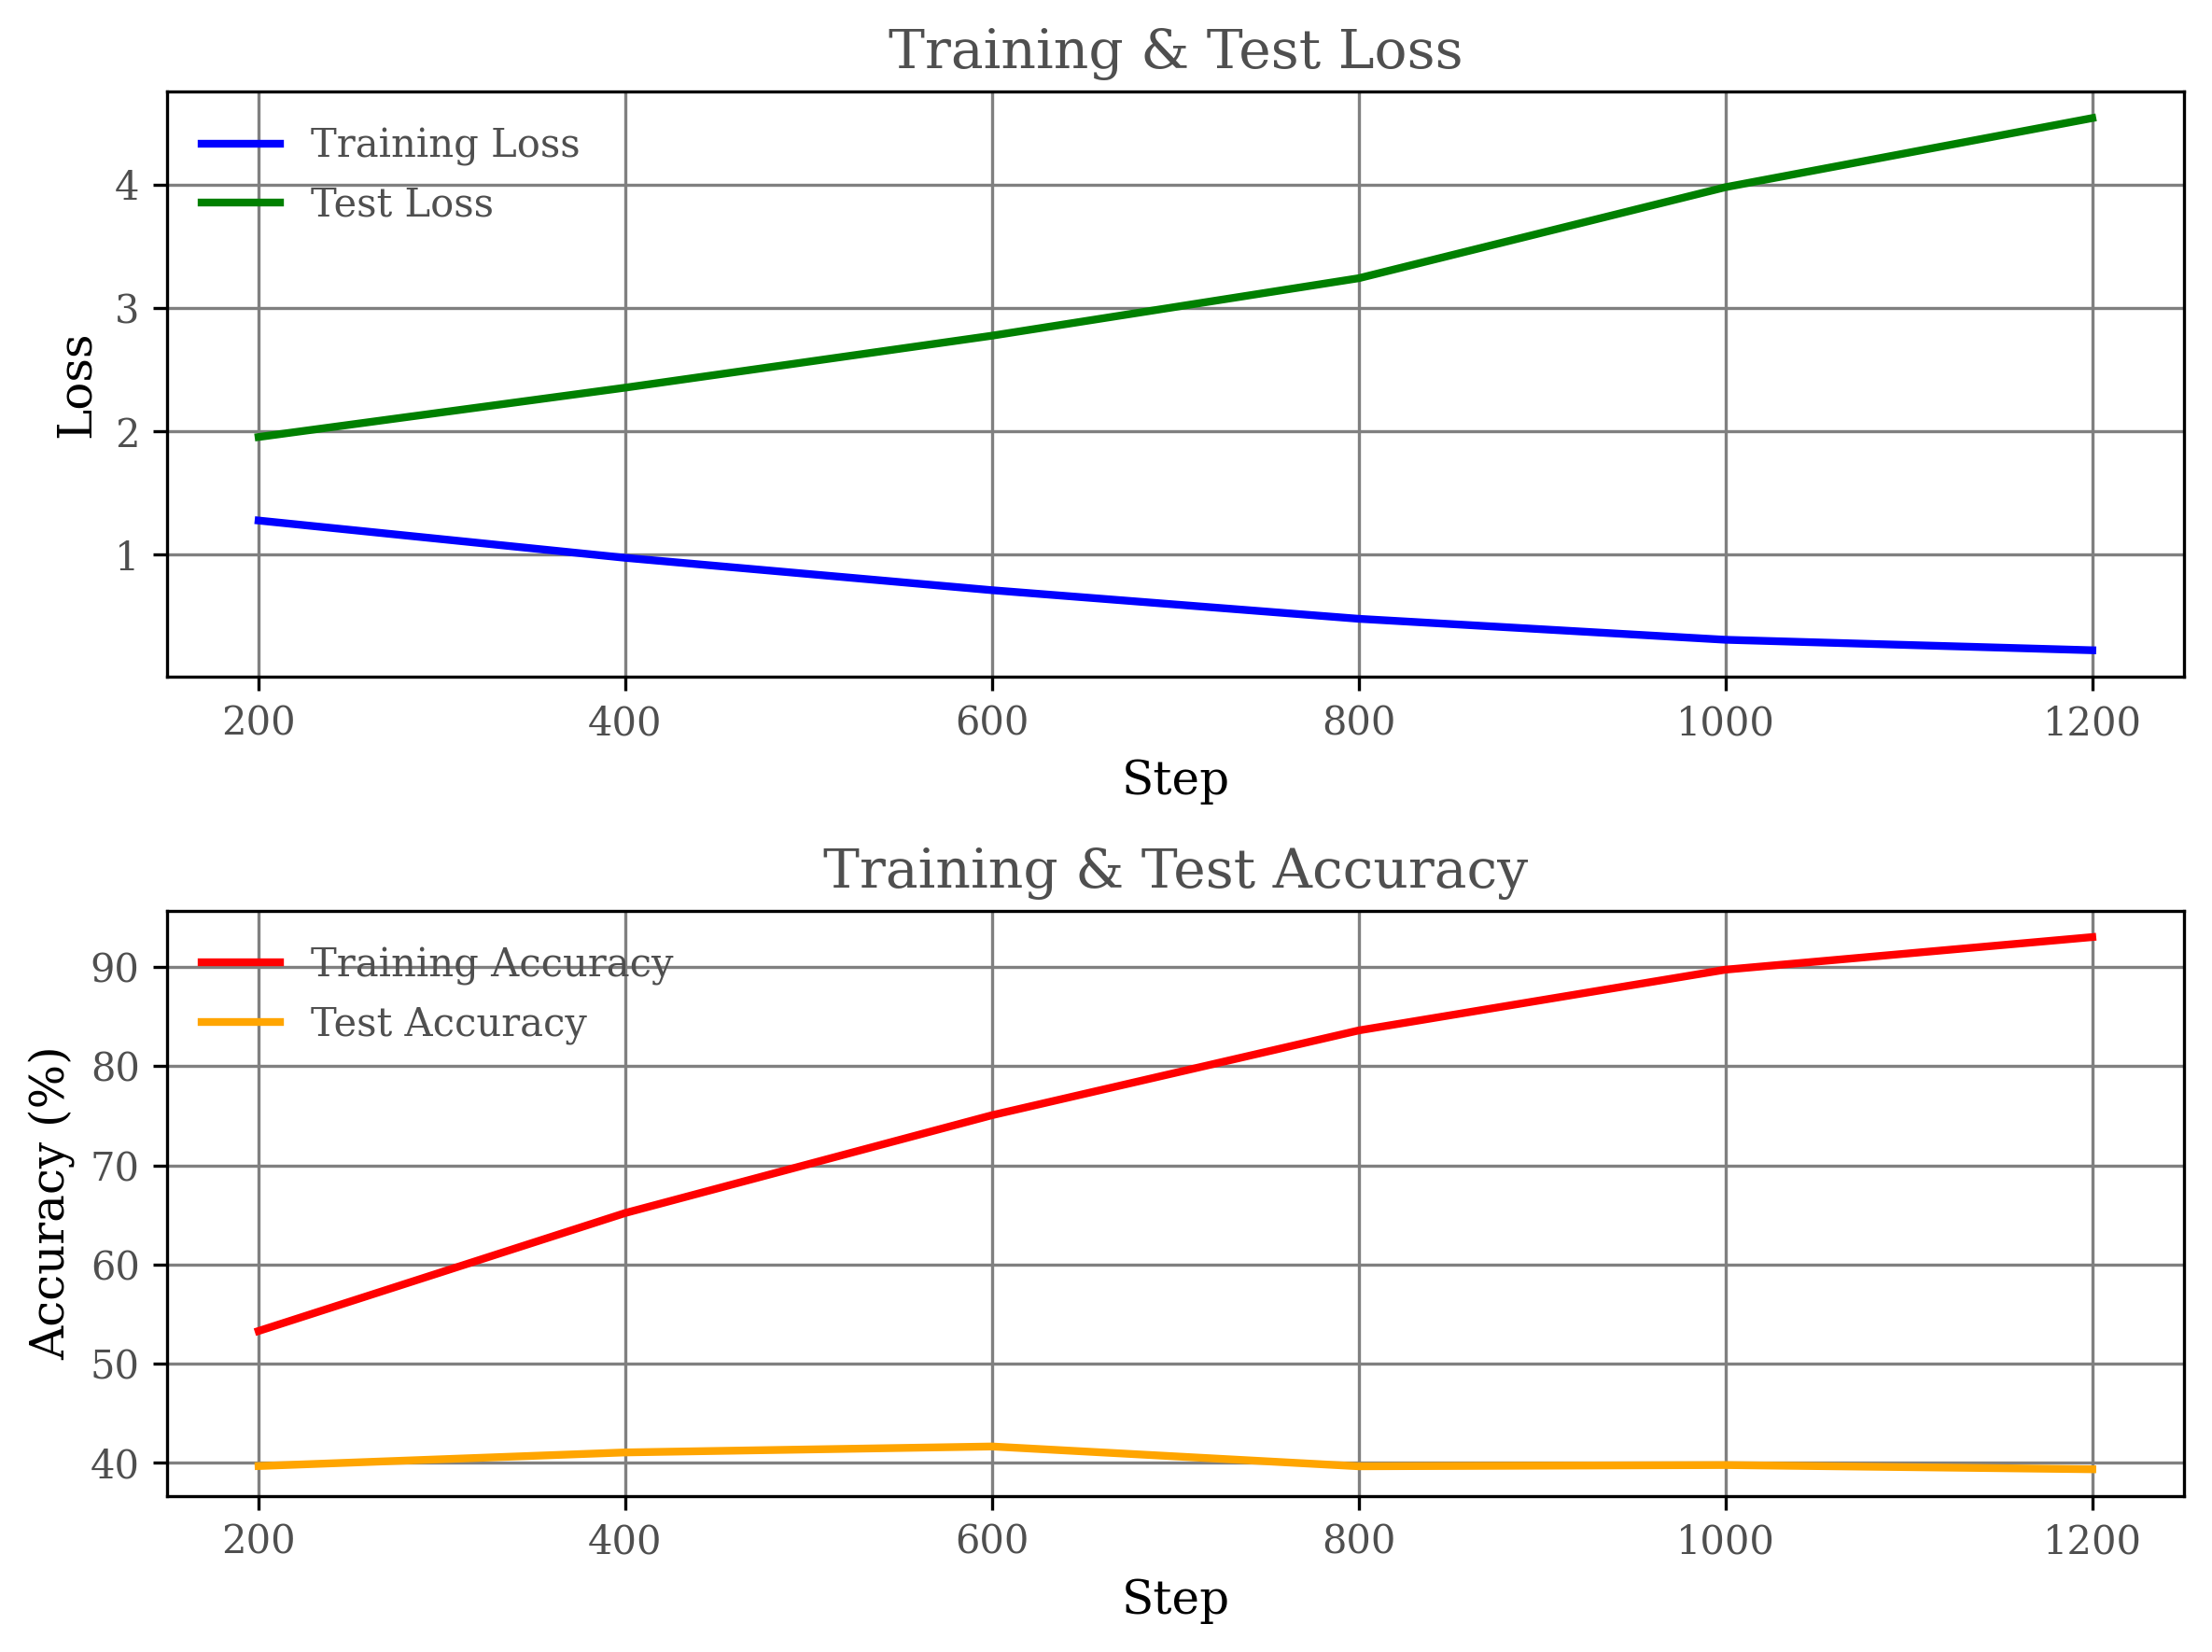

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# 假设每个epoch的训练步数是batch_size，这里我们先假设是100，实际值需要根据你的设置修改
steps_per_epoch = 6400 / 32  # 例如每个epoch有100个step

# 提取数据
training_loss = [x['train_loss'] for x in log]
training_acc = [x['train_accuracy'] for x in log]
test_loss = [x['val_loss'] for x in log]
test_acc = [x['val_accuracy'] for x in log]

# 计算step数量
steps = [epoch * steps_per_epoch for epoch in range(1, len(log) + 1)]

# 使用滑动平均进行平滑
def smooth(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 平滑处理
smooth_train_loss = smooth(training_loss)
smooth_test_loss = smooth(test_loss)
smooth_train_acc = smooth(training_acc)
smooth_test_acc = smooth(test_acc)

# 创建两个子图，调整图表大小
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=300)

# 设置字体和字体颜色为深灰色
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'text.color': '#4F4F4F'})

# 绘制平滑后的损失曲线
ax1.plot(steps[:len(smooth_train_loss)], smooth_train_loss, label='Training Loss', color='blue', linewidth=2)
ax1.plot(steps[:len(smooth_test_loss)], smooth_test_loss, label='Test Loss', color='green', linewidth=2)
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Test Loss', fontsize=14)
ax1.legend(fontsize=10, frameon=False)  # 设置图例背景透明
ax1.grid(True, color='gray')  # 设置网格线为灰色
ax1.tick_params(axis='both', labelcolor='#4F4F4F')  # 设置坐标轴刻度和标签的颜色为深灰色

# 设置坐标轴框体颜色为黑色
ax1.spines['top'].set_color('#000000')  # 黑色
ax1.spines['bottom'].set_color('#000000')
ax1.spines['left'].set_color('#000000')
ax1.spines['right'].set_color('#000000')

# 绘制平滑后的准确率曲线
ax2.plot(steps[:len(smooth_train_acc)], smooth_train_acc, label='Training Accuracy', color='red', linewidth=2)
ax2.plot(steps[:len(smooth_test_acc)], smooth_test_acc, label='Test Accuracy', color='orange', linewidth=2)
ax2.set_xlabel('Step', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training & Test Accuracy', fontsize=14)
ax2.legend(fontsize=10, frameon=False)  # 设置图例背景透明
ax2.grid(True, color='gray')  # 设置网格线为灰色
ax2.tick_params(axis='both', labelcolor='#4F4F4F')  # 设置坐标轴刻度和标签的颜色为深灰色

# 设置坐标轴框体颜色为黑色
ax2.spines['top'].set_color('#000000')  # 黑色
ax2.spines['bottom'].set_color('#000000')
ax2.spines['left'].set_color('#000000')
ax2.spines['right'].set_color('#000000')

# 调整图形布局
fig.tight_layout()
plt.savefig('./figures/TCNNbase.pdf', dpi=300, transparent=True)
# 显示图形
plt.show()


In [54]:
from model import CRNNwithResNet

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNNwithResNet(num_classes=8, resnet="resnet18").to(device)

In [56]:
summary(model, (1, 1, 96, 1366))

Layer (type:depth-idx)                        Output Shape              Param #
CRNNwithResNet                                [1, 8]                    --
├─Conv2d: 1-1                                 [1, 3, 96, 1366]          6
├─Sequential: 1-2                             [1, 512, 1, 43]           --
│    └─Conv2d: 2-1                            [1, 64, 48, 683]          9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 48, 683]          128
│    └─ReLU: 2-3                              [1, 64, 48, 683]          --
│    └─MaxPool2d: 2-4                         [1, 64, 24, 342]          --
│    └─Sequential: 2-5                        [1, 64, 24, 342]          --
│    │    └─BasicBlock: 3-1                   [1, 64, 24, 342]          73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 24, 342]          73,984
│    └─Sequential: 2-6                        [1, 128, 12, 171]         --
│    │    └─BasicBlock: 3-3                   [1, 128, 12, 171]         230,144
│   

In [78]:
from model import MultibranchLSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultibranchLSTM(num_classes=8, resized=True).to(device)

In [80]:
torch.onnx.export(model, (torch.randn(1, 3, 128, 2366).to(device)), "multibranch.onnx")